In [1]:
import pandas as pd
import keras 
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
path_ref = "PlantVillage"
img_list = list(Path(path_ref).glob("*/*.JPG"))

In [4]:
base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(256,256,3))

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(15,activation='softmax')    
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               37749248  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 59,559,727
Trainable params: 37,756,943
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [9]:
df = pd.DataFrame()

for folder in os.listdir(path_ref):
    folder_path = os.path.join(path_ref, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                df = df._append({'filename': file_path, 'label': folder}, ignore_index=True)

df.head()

,filename,label
0,PlantVillage\Pepper__bell___Bacterial_spot\002...,Pepper__bell___Bacterial_spot
1,PlantVillage\Pepper__bell___Bacterial_spot\006...,Pepper__bell___Bacterial_spot
2,PlantVillage\Pepper__bell___Bacterial_spot\00f...,Pepper__bell___Bacterial_spot
3,PlantVillage\Pepper__bell___Bacterial_spot\016...,Pepper__bell___Bacterial_spot
4,PlantVillage\Pepper__bell___Bacterial_spot\016...,Pepper__bell___Bacterial_spot


In [10]:
df.sample(10)

,filename,label
12173,PlantVillage\Tomato_Leaf_Mold\f7826d86-2eb1-40...,Tomato_Leaf_Mold
17544,PlantVillage\Tomato__Tomato_YellowLeaf__Curl_V...,Tomato__Tomato_YellowLeaf__Curl_Virus
8589,PlantVillage\Tomato_healthy\83781ea3-eaed-467a...,Tomato_healthy
18697,PlantVillage\Tomato__Tomato_YellowLeaf__Curl_V...,Tomato__Tomato_YellowLeaf__Curl_Virus
17670,PlantVillage\Tomato__Tomato_YellowLeaf__Curl_V...,Tomato__Tomato_YellowLeaf__Curl_Virus
16104,PlantVillage\Tomato__Target_Spot\5a084ee2-7a6d...,Tomato__Target_Spot
9728,PlantVillage\Tomato_Late_blight\30f95811-1559-...,Tomato_Late_blight
6397,PlantVillage\Tomato_Bacterial_spot\d8e40874-f1...,Tomato_Bacterial_spot
6440,PlantVillage\Tomato_Bacterial_spot\de2b6ef8-f5...,Tomato_Bacterial_spot
4929,PlantVillage\Tomato_Bacterial_spot\25a94cb1-a3...,Tomato_Bacterial_spot


In [11]:
train,test = train_test_split(df,test_size=0.3,random_state=42)

In [12]:
datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,shear_range=0.3)

In [13]:
train_generator = datagen.flow_from_dataframe(train,x_col='filename',y_col='label',target_size=(256,256),batch_size=32,class_mode='categorical',)
val_generator = datagen.flow_from_dataframe(test,x_col='filename',y_col='label',target_size=(256,256),batch_size=32,class_mode='categorical')

C:\Users\tunce\anaconda3\envs\Gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 14446 validated image filenames belonging to 15 classes.
Found 6192 validated image filenames belonging to 15 classes.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5,monitor='loss',restore_best_weights=True)

In [15]:
history = model.fit(train_generator,validation_data=val_generator,epochs=50,callbacks=[es])

Epoch 1/50
452/452 [==============================] - 269s 564ms/step - loss: 2.8080 - accuracy: 0.6193 - val_loss: 0.6622 - val_accuracy: 0.7778
Epoch 2/50
452/452 [==============================] - 245s 541ms/step - loss: 0.7533 - accuracy: 0.7487 - val_loss: 0.5801 - val_accuracy: 0.8098
Epoch 3/50
452/452 [==============================] - 245s 542ms/step - loss: 0.6242 - accuracy: 0.7903 - val_loss: 0.5117 - val_accuracy: 0.8351
Epoch 4/50
452/452 [==============================] - 245s 543ms/step - loss: 0.5262 - accuracy: 0.8187 - val_loss: 0.4179 - val_accuracy: 0.8690
Epoch 5/50
452/452 [==============================] - 245s 542ms/step - loss: 0.4686 - accuracy: 0.8404 - val_loss: 0.4332 - val_accuracy: 0.8626
Epoch 6/50
452/452 [==============================] - 244s 539ms/step - loss: 0.4529 - accuracy: 0.8420 - val_loss: 0.4179 - val_accuracy: 0.8668
Epoch 7/50
452/452 [==============================] - 249s 550ms/step - loss: 0.4005 - accuracy: 0.8604 - val_loss: 0.4157 -

In [16]:
tf.keras.models.save_model(model, "Inceptionv3.Model")

INFO:tensorflow:Assets written to: Inceptionv3.Model\assets


In [21]:
scores = model.evaluate(val_generator)

194/194 [==============================] - 74s 382ms/step - loss: 0.4885 - accuracy: 0.9058


In [22]:
scores

[0.4885329604148865, 0.9058462381362915]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 452}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

48

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.808025360107422,
 0.7533153891563416,
 0.624162495136261,
 0.5262341499328613,
 0.46855148673057556]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
epochs = 48

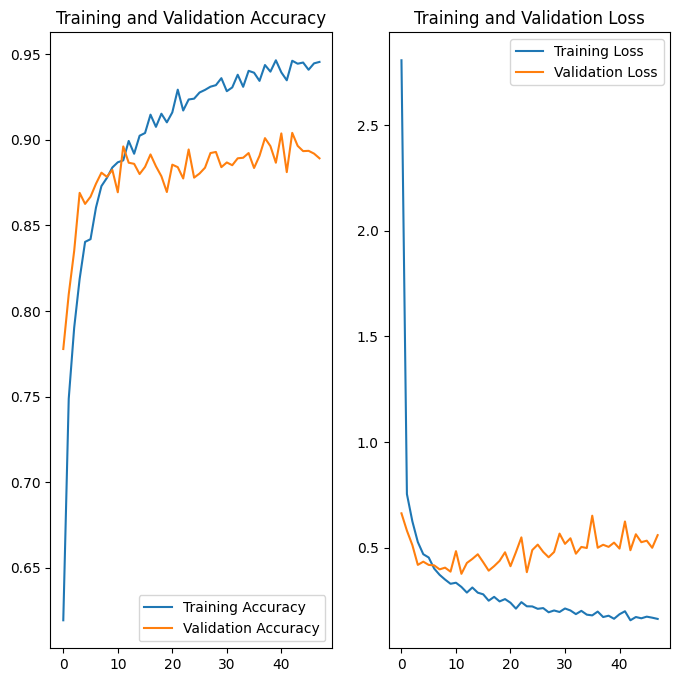

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
import numpy as np
for images_batch, labels_batch in validation_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'validation_data' is not defined

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")